# Explore here

## Step 1: Problem statement and data collection

Problem statement: What price should an AirBnB host anticipate being able to charge, based on prices of existing AirBnBs with some similar and some different characteristics?

In [141]:
# Import dataset to start working with it
import pandas as pd

raw_data = pd.read_csv("../data/raw/AB_NYC_2019.csv")


## Step 2: Exploration and data cleaning

In [142]:
print(f"Raw data shape: {raw_data.shape}")
print(raw_data.info())

Raw data shape: (48895, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last

Looks like the columns with missing data are: name, host_name, last_review, reviews_per_month.

Name and host_name should have negligible or no effect on price.
last_review and reviews_per_month sound plausible to indirectly correlate (i.e. a place with more reviews per time period likely got more bookings; more bookings correlates to less time unbooked; that correlates to a venue that is more in-demand and as such can likely charge a higher price per booking).

But we may be able to get away with ignoring them rather than trying to make some convoluted fictional values in place of missing values.

In [143]:
print(
    f"Count of duplicates found based on id: {raw_data.drop('id', axis=1).duplicated().sum()}"
)

# Looks at every column except id. Two rows are considered the “same” if all of those other columns match, even when their id values differ.
# raw_data = raw_data.drop_duplicates(subset = raw_data.columns.difference(['id']))

#  Looks at all columns (because subset is omitted). Two rows are duplicates only if every column—including id—matches.
raw_data = raw_data.drop_duplicates()

print(raw_data.shape)
raw_data.head()

Count of duplicates found based on id: 0
(48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [144]:
# remove data considered irrelevant
raw_data.drop(
    ["id", "name", "host_name", "last_review", "reviews_per_month"],
    axis=1,
    inplace=True,
)
# dropped last_review and reviews_per_month because these are columns containinng missing / NaN values
# and I was indecisive about whether/how to impute dummy values for them.

# dropping lat & long because when I asked about them during office hours,
# it sounded like it'd be bothersome to try to render something in Codespaces like a heatmap overlaid on a satellite map,
# and these sound in some ways redundant with neighborhood & neighborhood_groups anyway
raw_data.drop(["latitude", "longitude"], axis=1, inplace=True)

raw_data.head()

,host_id,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,Private room,149,1,9,6,365
1,2845,Manhattan,Midtown,Entire home/apt,225,1,45,2,355
2,4632,Manhattan,Harlem,Private room,150,3,0,1,365
3,4869,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,1,194
4,7192,Manhattan,East Harlem,Entire home/apt,80,10,9,1,0


## Step 3: Analysis of univariate variables
### categorical variables
Categorical, non-numreric variables in this dataframe include: host_id, neighbourhood_group, neighbourhood, room_type

I can easily imagine a competent host being better-able to charge a high fee vs. someone less talented, so am including it in variables.

host_id looks numeric, but it's really just an anonymized form of name.  It can also exist across multiple properties managed by the same host, pulling the price in a similar up vs. down direction across each.


In [145]:
categorical_variables = ["host_id", "neighbourhood_group", "neighbourhood", "room_type"]

for each_categorical_variable in categorical_variables:
    print(f"\n\t{each_categorical_variable}s:")
    for each_possible_value in sorted(
        raw_data[f"{each_categorical_variable}"].unique()
    ):
        print(each_possible_value)


	host_ids:
2438
2571
2787
2845
2868
2881
3151
3211
3415
3563
3647
3867
4396
4632
4869
5089
6041
6485
7192
7209
7310
7322
7351
7355
7356
7490
7500
7549
7702
7989
8198
8425
8440
8605
8703
8730
8967
9744
10135
10528
10889
11175
11481
11528
11975
12220
12221
14063
14356
14370
14444
14751
15154
15192
15387
15523
15574
15742
15784
15977
15991
16800
16866
17571
17930
17985
18174
18282
18283
18742
18946
19342
19402
19562
20805
20950
21188
21207
21248
21306
21475
21823
21904
22188
22323
22462
22486
23193
23276
23619
23633
23684
24069
24222
24347
25100
25183
25326
25459
25632
25810
26394
26640
27245
27848
28250
28336
28422
28573
29096
29213
29506
30193
30529
31374
31378
31994
32045
32169
32228
32294
32704
32800
33009
33510
33655
33816
34331
34915
35375
35935
35944
36119
36841
36897
37413
37879
38513
39260
39304
39322
40100
40275
40502
41358
41612
42032
42273
42761
43321
43671
43772
44145
44263
45009
45384
45445
45609
45682
46719
46969
46978
47459
47532
47610
47618
47727
48165
48581
48599
49405


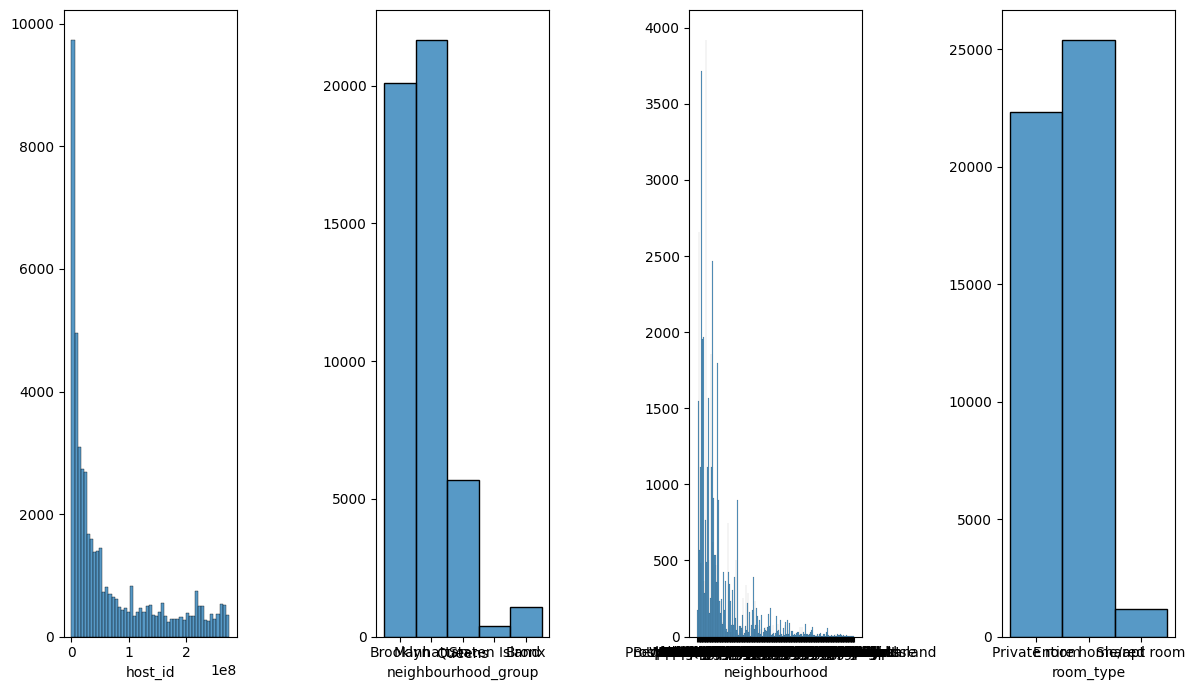

: 

In [ ]:
# histogram-plot each categorical variable

import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(1, 4, figsize=(12, 7))

# Create a multiple histogram
sns.histplot(ax=axis[0], data=raw_data, x="host_id").set(ylabel=None)
sns.histplot(ax=axis[1], data=raw_data, x="neighbourhood_group").set(ylabel=None)
sns.histplot(ax=axis[2], data=raw_data, x="neighbourhood").set(ylabel=None)
sns.histplot(ax=axis[3], data=raw_data, x="room_type").set(ylabel=None)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

- Most hosts had fewer than 1,750 listings, but a handful of perhaps-professionals had anywhere from >2,000 to nearly 10,000 listings.
- Most AirBnBs were in Brooklyn, Manhattan, or to a lesser extent Queens.
- Far more private or entire home/apartment rooms were listed; far fewer shared rooms.
- Certain neighborhoods were much more commonly listed than others; this likely corresponds to them being in more-represented neighborhood groups

### numeric variables

Numerical, non-categorical variables in the dataset include: price, minimum_nights, number_of_reviews, calculated_host_listings_count, availability_365.  

In [ ]:
numeric_variables = [
    "price",
    "minimum_nights",
    "number_of_reviews",
    "calculated_host_listings_count",
    "availability_365",
]
fig, axis = plt.subplots(
    2, len(numeric_variables), figsize=(25, 7), gridspec_kw={"height_ratios": [6, 1]}
)

# Creating a multiple figure with histograms and box plots
temp_column_index = 0
for each_numeric_variable in numeric_variables:
    sns.histplot(
        ax=axis[0, temp_column_index], data=raw_data, x=f"{each_numeric_variable}"
    ).set(xlabel=None, ylabel=None)
    sns.boxplot(
        ax=axis[1, temp_column_index], data=raw_data, x=f"{each_numeric_variable}"
    )
    temp_column_index += 1

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


From this it looks like:
- most units charge under $500 (a night?) but there are some more-expensive outliers
- most places allow a minimum stay of only one night but at least a few outliers look like they're being listed for multi-year contracts
- most places have few if any reviews but the "tail" on that histogram skews longer into the low hundreds
- if I'm correctly understanding "calculated host listings count" then the majority of hosts have only a handful or at most a few dozen listings, whereas there are outliers who've listed dozens to hundreds
- many listings are available either only during a few nights of the year (maybe for popular holidays/events such as New Year's Eve or the Thanksgiving Day Parades?) and there's a noticeable histogram spike at beiung available year-round; the rest are typically available around 225 days a year. 

## Step 4: Analysis of multivariate variables
### Numerical-numerical analysis
I've hypothesized that a more-reviewed property is a more-booked property, that a more-booked property is a more in-demand property, and that a more in-demand property should be listing for a higher price.  Similar could be true of relatiung price to calculated_host_listings_count, if that's an expression of a host having booked more often or more in total.  I'm curious to see how those seem to correlate...

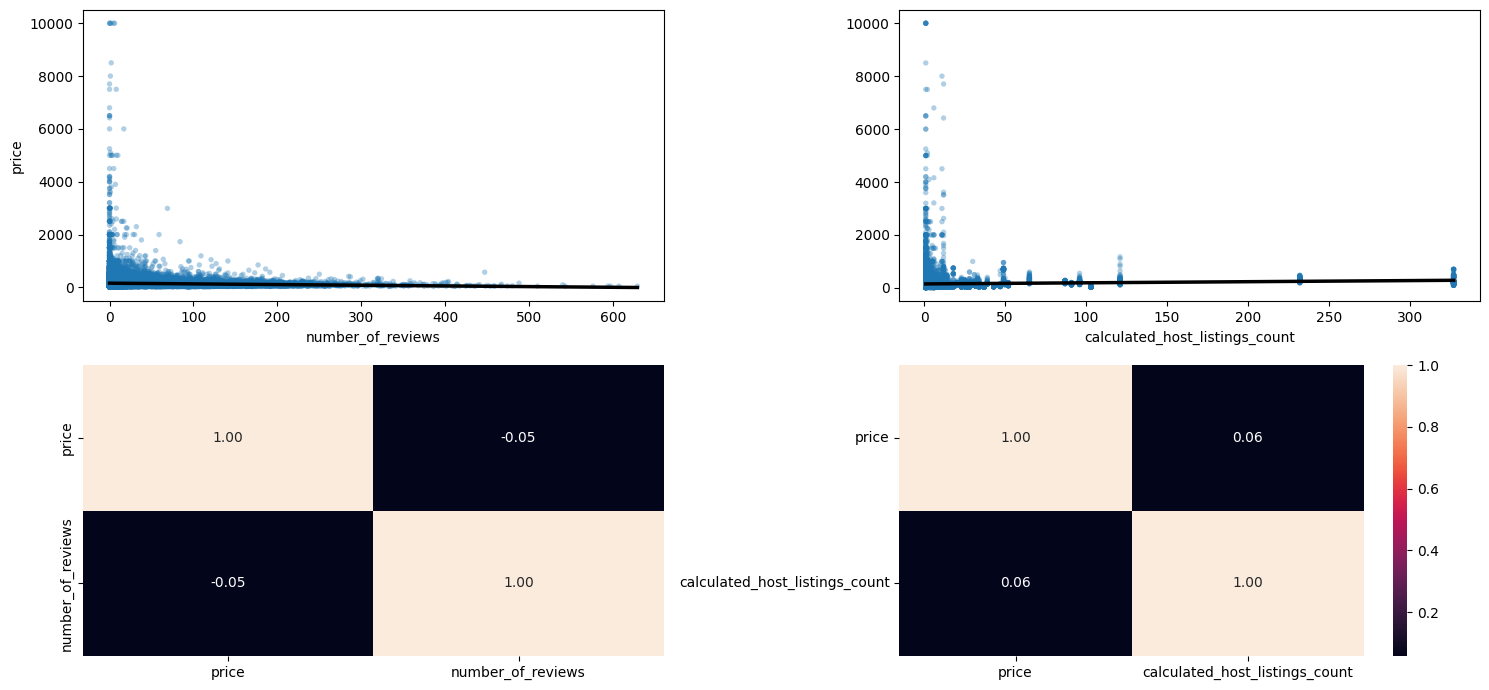

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(15, 7))

# Create a multiple scatter diagram
common_scatter = {"s": 15, "alpha": 0.35, "edgecolor": "none"}
common_line = {"color": "black", "lw": 2.5, "zorder": 5}

sns.regplot(
    ax=axis[0, 0],
    data=raw_data,
    x="number_of_reviews",
    y="price",
    scatter_kws=common_scatter,
    line_kws=common_line,
)
sns.heatmap(
    raw_data[["price", "number_of_reviews"]].corr(),
    annot=True,
    fmt=".2f",
    ax=axis[1, 0],
    cbar=False,
)

sns.regplot(
    ax=axis[0, 1],
    data=raw_data,
    x="calculated_host_listings_count",
    y="price",
    scatter_kws=common_scatter,
    line_kws=common_line,
).set(ylabel=None)
sns.heatmap(
    raw_data[["price", "calculated_host_listings_count"]].corr(),
    annot=True,
    fmt=".2f",
    ax=axis[1, 1],
)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

Based on this it looks like the correlations between quantity of reviews and price are slight, and in the opposite direction of what I'd hypothesized; I'd explain this by thinking that a more-affordable property is more likely to get booked by someone who is both opinionated & outspoken enough to take the time to leave a review.

Meawhile there's a similar-scale positive correlation between listings count and price, so yes, someone who's been putting up more listings typically commands a higher price for them, but not by as much as I might've guessed.

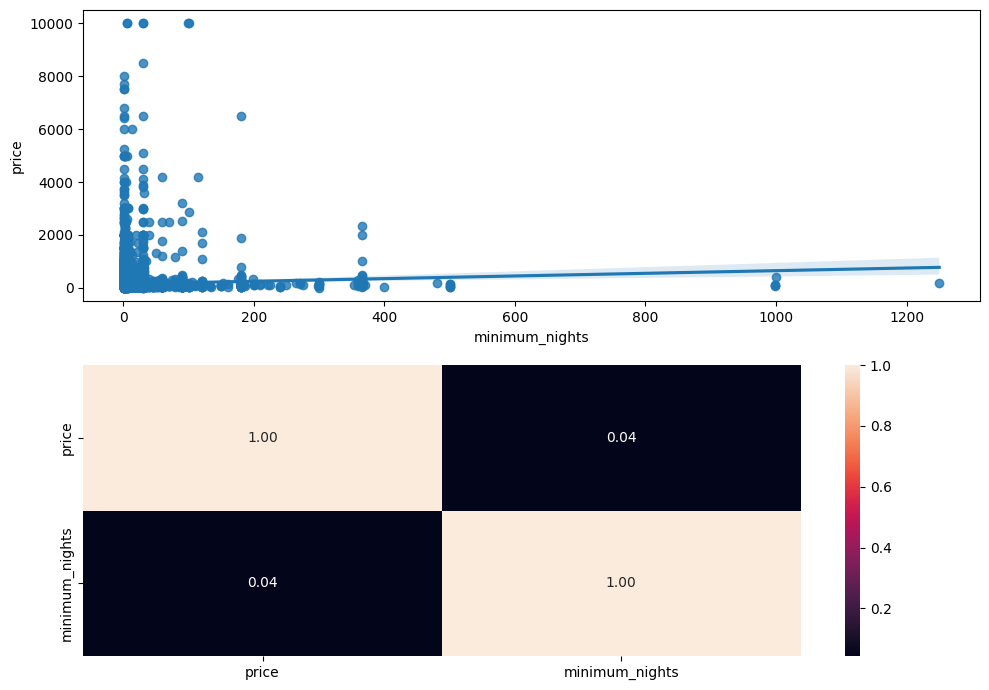

In [ ]:
# I'm curious whether there's a strong correlation or little to no correlation between minimum_nights and price

fig, axis = plt.subplots(2, 1, figsize=(10, 7))

# Create a multiple scatter diagram
sns.regplot(ax=axis[0], data=raw_data, x="minimum_nights", y="price")
sns.heatmap(
    raw_data[["price", "minimum_nights"]].corr(), annot=True, fmt=".2f", ax=axis[1]
)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

Seems like there's even less/weaker of a correlation between minimum nights & price than there was a correlation between price and either of the other two numeric variables discussed above.

### categorical-categorical analysis

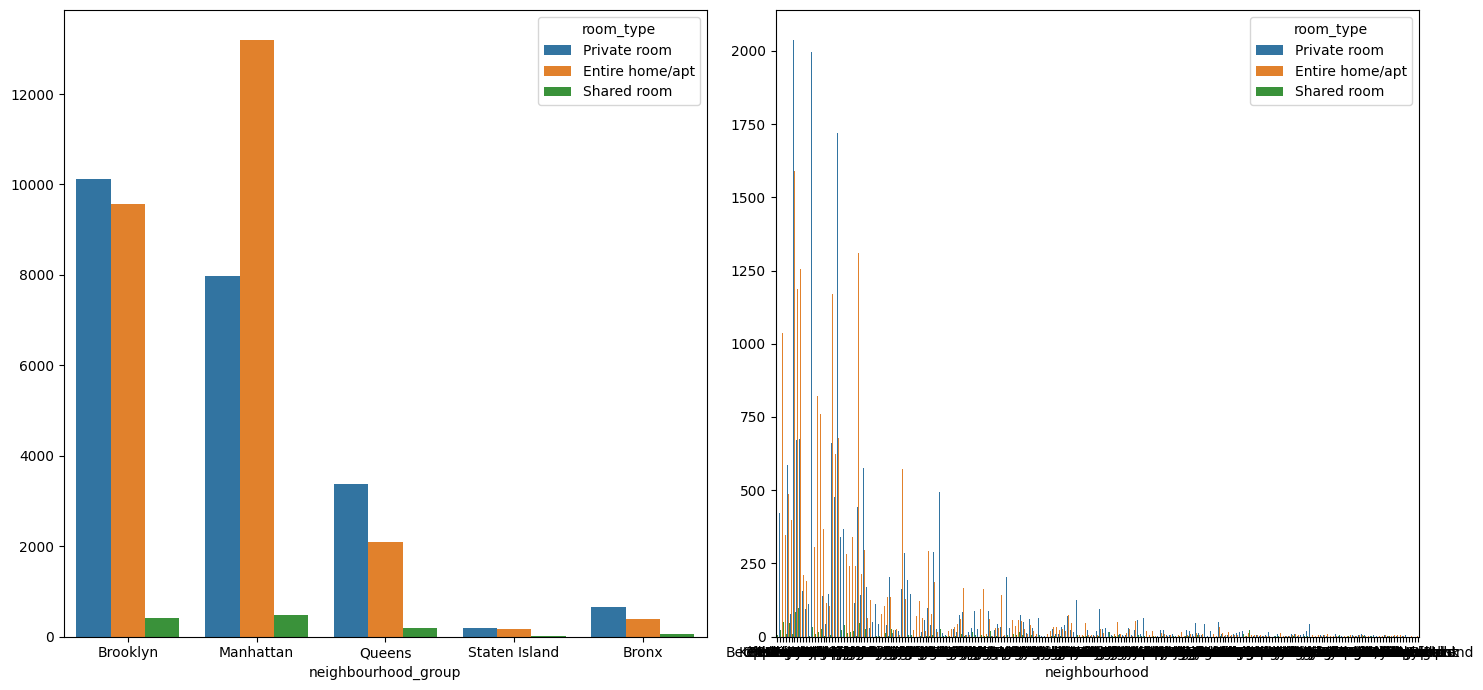

['host_id', 'neighbourhood_group', 'neighbourhood', 'room_type']


In [ ]:
# I'd guess certain home types are more commonly listed in some areas vs. others,
# e.g. in which neighborhoods is it easier or more difficult to find a whole home/apt vs. a private room vs. a shared room?

fig, axis = plt.subplots(1, 2, figsize=(15, 7))

sns.countplot(ax=axis[0], data=raw_data, x="neighbourhood_group", hue="room_type").set(
    ylabel=None
)
sns.countplot(ax=axis[1], data=raw_data, x="neighbourhood", hue="room_type").set(
    ylabel=None
)


plt.tight_layout()

plt.show()


print(categorical_variables)

#### Correlation analysis
Seems reasonable to guess that price would be affected both by neighborhood group and room type...

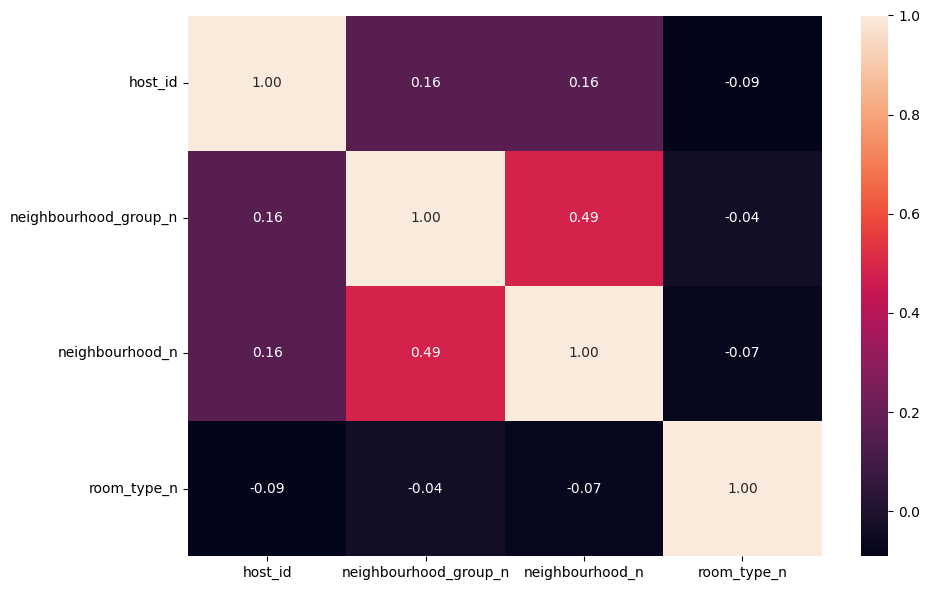

In [ ]:
raw_data["neighbourhood_group_n"] = pd.factorize(raw_data["neighbourhood_group"])[0]
raw_data["neighbourhood_n"] = pd.factorize(raw_data["neighbourhood"])[0]

# some room types are more luxurious than others; can express this by not just minimally factorizing by first appearance
room_order = ["Shared room", "Private room", "Entire home/apt"]
raw_data["room_type_cat"] = pd.Categorical(
    raw_data["room_type"],
    categories=room_order,
    ordered=True,  # the most important difference beteen this and the factorize one-liners
)
raw_data["room_type_n"] = raw_data["room_type_cat"].cat.codes


fig, axis = plt.subplots(figsize=(10, 6))

sns.heatmap(
    raw_data[
        ["host_id", "neighbourhood_group_n", "neighbourhood_n", "room_type_n"]
    ].corr(),
    annot=True,
    fmt=".2f",
)

plt.tight_layout()

plt.show()

Based on the above, looks like theres an unsurprisingly-strong correlation between neighbourhood & what neighbourhood group it's in, and some correlation between who's hosting & which neighborhood(s) they host in, but less correlation than I would've guessed between either of those & room type.

### numerical-categorical analysis

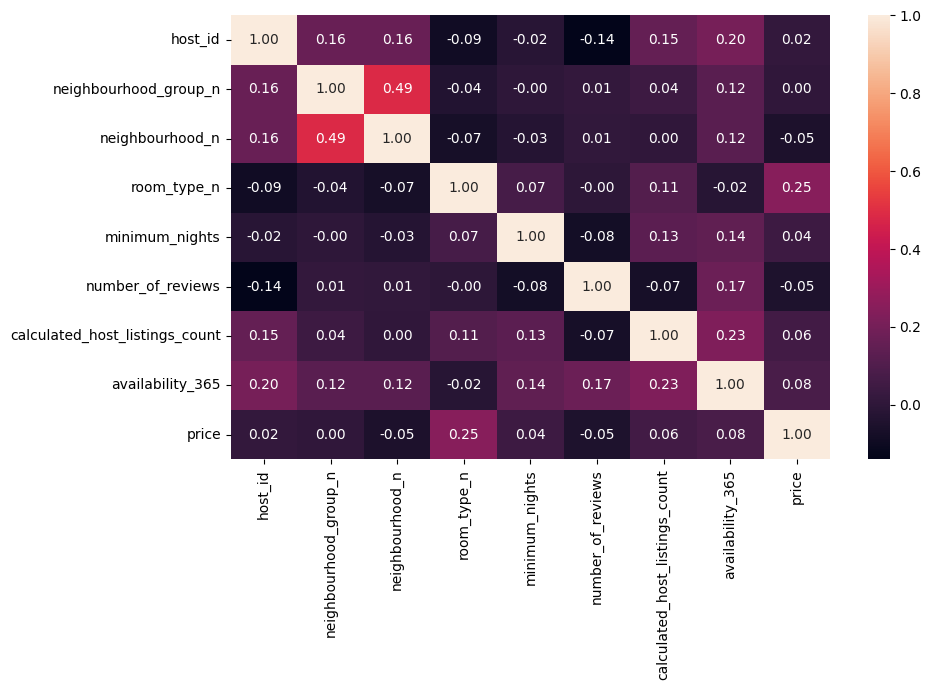

In [ ]:
fig, axis = plt.subplots(figsize=(10, 7))

sns.heatmap(
    raw_data[
        [
            "host_id",
            "neighbourhood_group_n",
            "neighbourhood_n",
            "room_type_n",
            "minimum_nights",
            "number_of_reviews",
            "calculated_host_listings_count",
            "availability_365",
            "price",
        ]
    ].corr(),
    annot=True,
    fmt=".2f",
)

plt.tight_layout()

plt.show()

Based on the above, I'd assess:
- the strongest determinant of price is room type, rather than location; neighborhood location has a surprising-to-me lack of influence on price
- the strongest determinants of room availability (proportionally throughout the year) are who's hosting it (some people appear more ready/willing/able to host than others), and to a slightly-lesser but still notable extent, neighborhood.
- more-available rooms tended to get booked more times (not surprising) and to a slightly leser but still-noticeable extent, tended to get more reviewed.

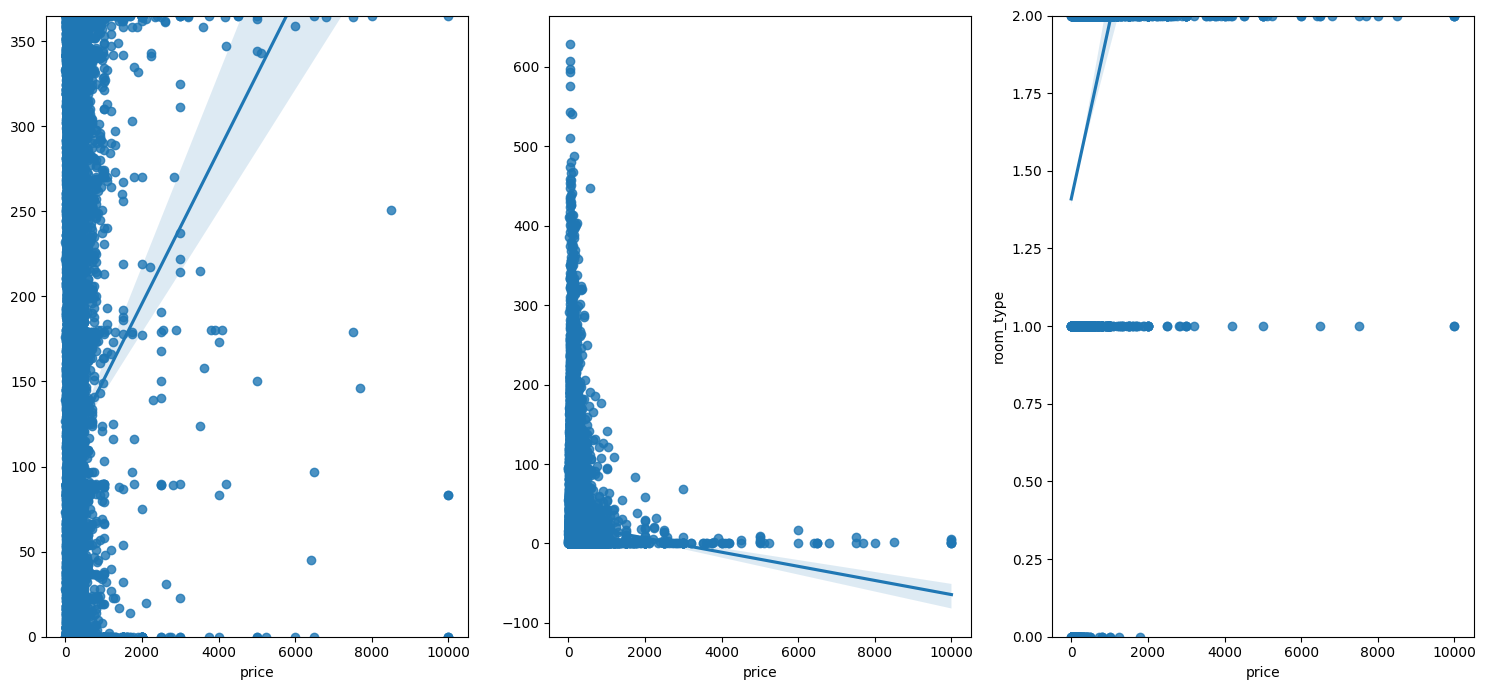

In [ ]:
fig, axis = plt.subplots(figsize=(15, 7), ncols=3)

sns.regplot(ax=axis[0], data=raw_data, x="price", y="availability_365").set(
    ylabel=None, ylim=(0, 365)
)
sns.regplot(ax=axis[1], data=raw_data, x="price", y="number_of_reviews").set(
    ylabel=None
)
sns.regplot(ax=axis[2], data=raw_data, x="price", y="room_type_n").set(
    ylabel="room_type", ylim=(0, 2)
)

plt.tight_layout()

plt.show()

Based on these regression plots:
- higher-cost listings tend to be available for more days of the year than lower-cost listings
- lower-cost listings tend to have more reviews written about them
- higher-end room types (e.g. whole-home instead of shared room) unsurprisingly tend to be higher-priced

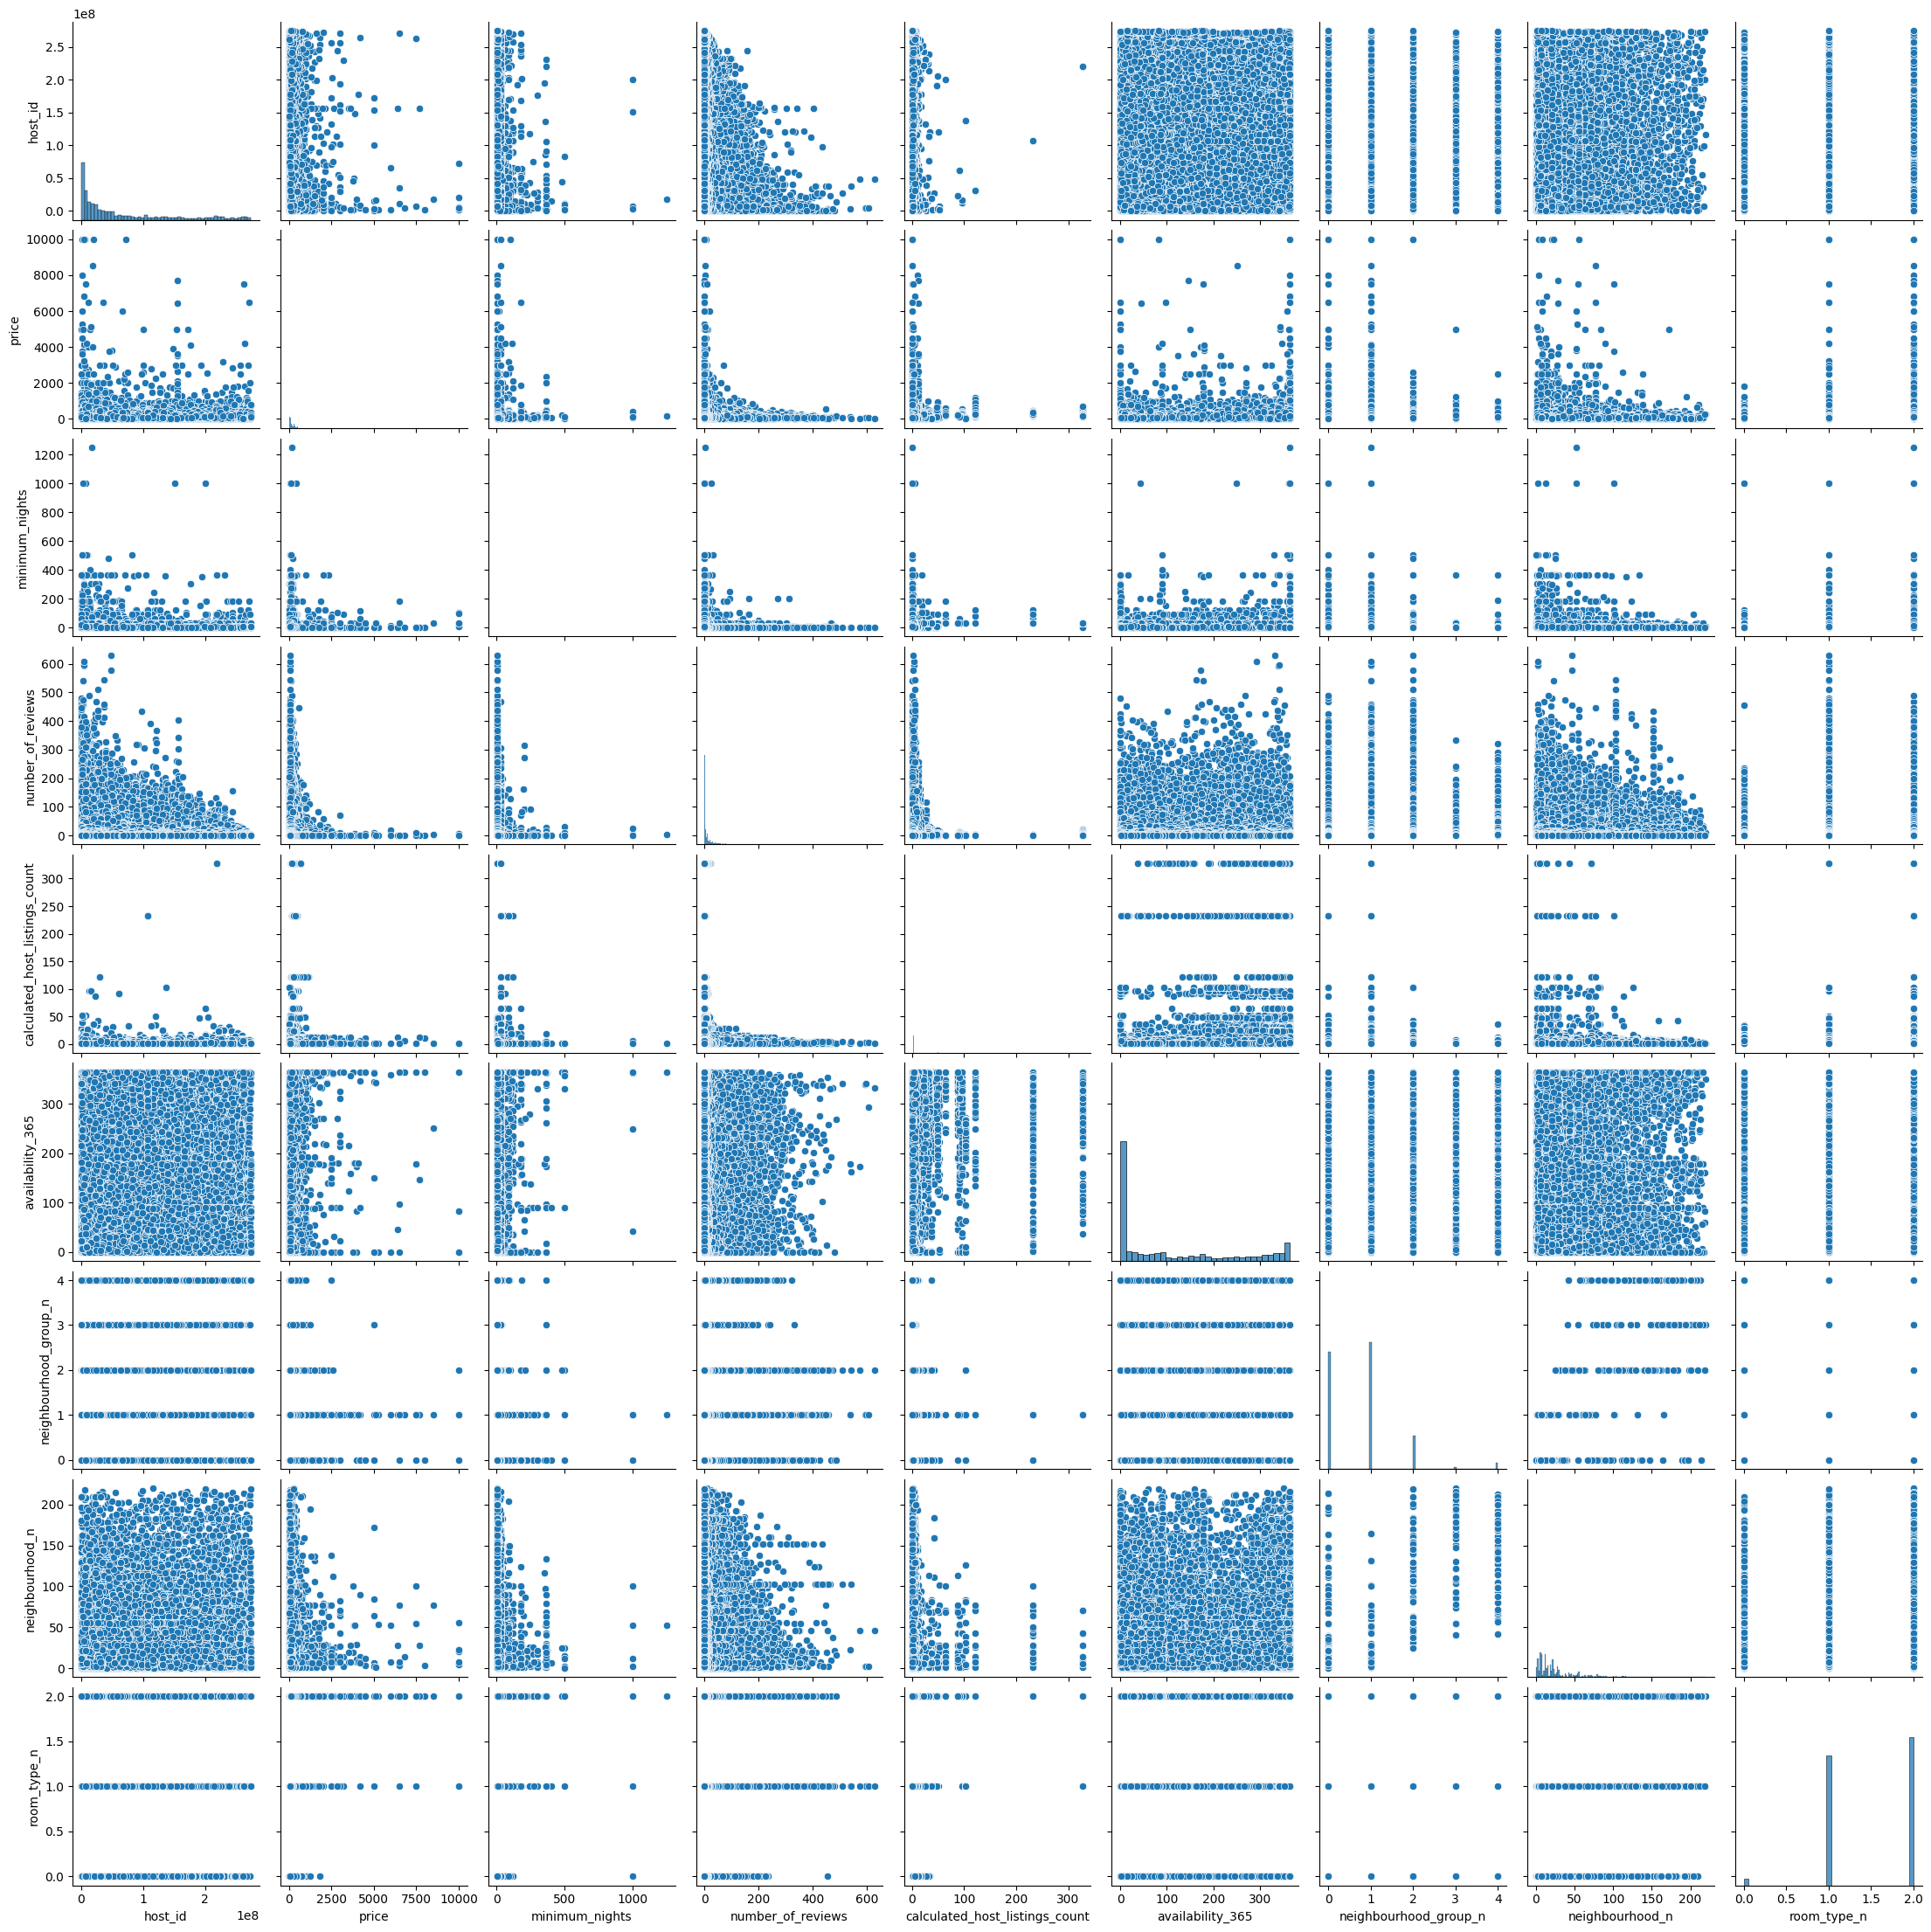

In [ ]:
sns.pairplot(data=raw_data)

### Day 2 exercises


In [ ]:
raw_data.describe()

,host_id,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_group_n,neighbourhood_n,room_type_n
count,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,6.762001e+07,152.720687,7.029962,23.274466,7.143982,112.781327,0.786911,29.888782,1.495940
std,7.861097e+07,240.154170,20.510550,44.550582,32.952519,131.622289,0.844386,34.676634,0.545379
min,2.438000e+03,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,7.822033e+06,69.000000,1.000000,1.000000,1.000000,0.000000,0.000000,7.500000,1.000000
50%,3.079382e+07,106.000000,3.000000,5.000000,1.000000,45.000000,1.000000,19.000000,2.000000
75%,1.074344e+08,175.000000,5.000000,24.000000,2.000000,227.000000,1.000000,37.000000,2.000000
max,2.743213e+08,10000.000000,1250.000000,629.000000,327.000000,365.000000,4.000000,220.000000,2.000000


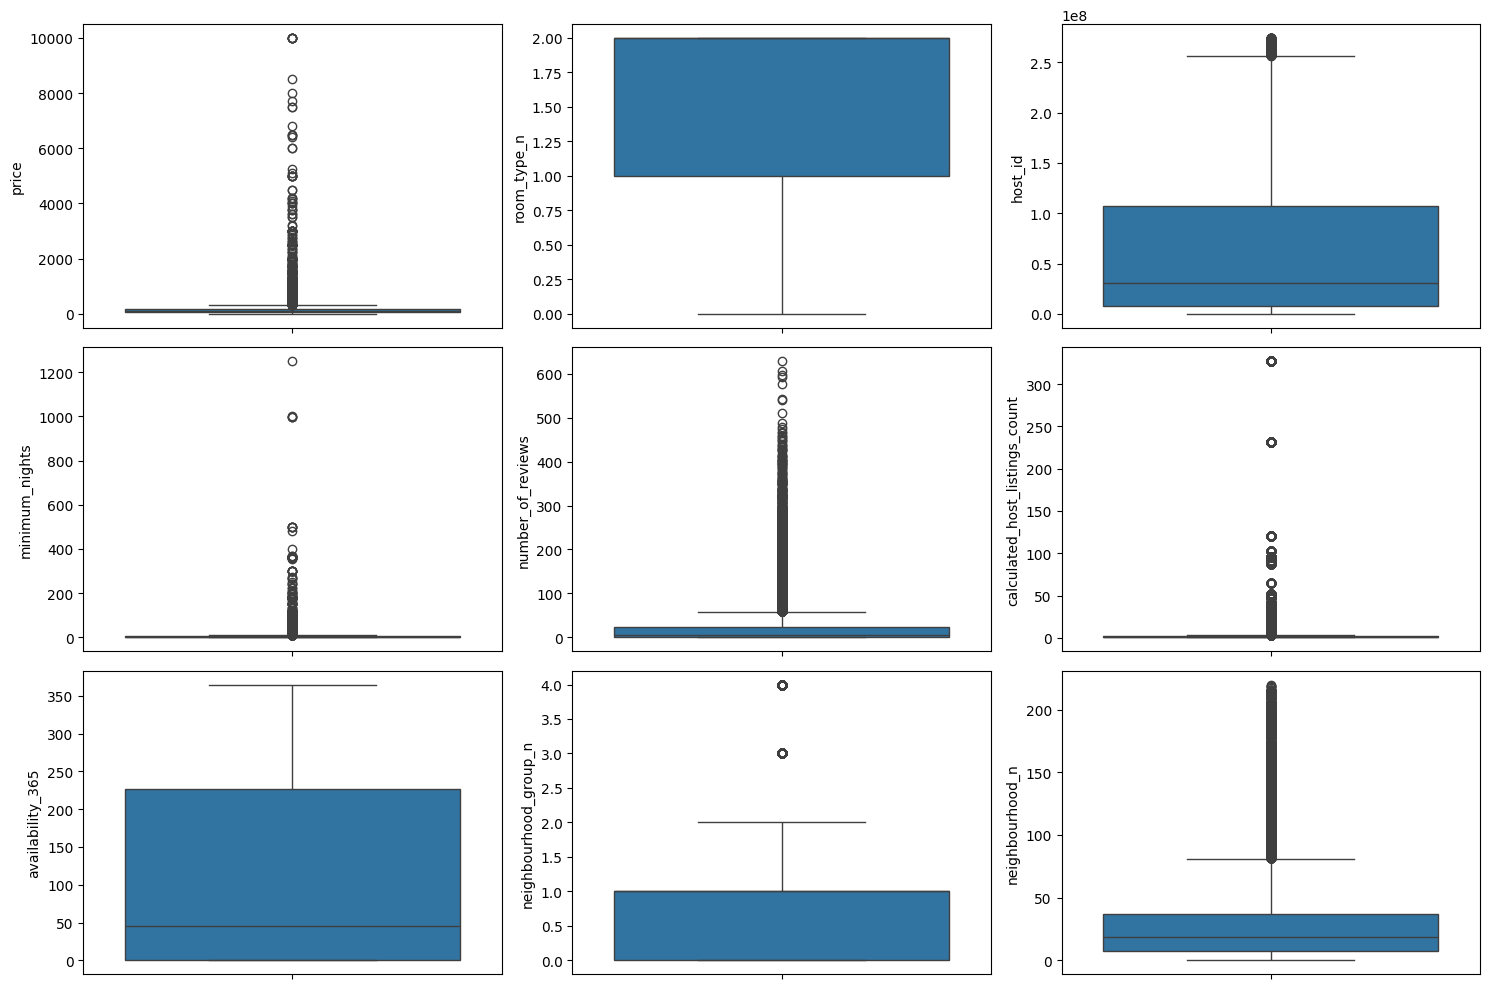

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(15, 10))

sns.boxplot(ax=axis[0, 0], data=raw_data, y="price")
sns.boxplot(ax=axis[0, 1], data=raw_data, y="room_type_n")
sns.boxplot(ax=axis[0, 2], data=raw_data, y="host_id")
sns.boxplot(ax=axis[1, 0], data=raw_data, y="minimum_nights")
sns.boxplot(ax=axis[1, 1], data=raw_data, y="number_of_reviews")
sns.boxplot(ax=axis[1, 2], data=raw_data, y="calculated_host_listings_count")
sns.boxplot(ax=axis[2, 0], data=raw_data, y="availability_365")
sns.boxplot(ax=axis[2, 1], data=raw_data, y="neighbourhood_group_n")
sns.boxplot(ax=axis[2, 2], data=raw_data, y="neighbourhood_n")

plt.tight_layout()

plt.show()

Items affected by outliers: price, minimum_nights, number_of_reviews, calculated_host_listings_count, neighbourhood_group, neighbourhood.

Maintain-eliminate-replace decisions: Most of these I'd keep.  The first exception is that I'd recommend eliminating rows for which minimum_nights is >1 or >2 years.  At that point landlords are using AirBnB to effectively sublet out a whole-year or multi-year rental property to a tenant, which seems like a different-enough business model vs. BnB that it's no longer an apples-to-apples comparison.

On talking about this more with a classmate he convinced me it's worth treating some of the higher-priced units as outliers, so I picked a threshold for that to remove those, too.

In [ ]:
print(raw_data["minimum_nights"].describe())
outlier_threshold_in_days = 365
long_stays = raw_data.query(f"minimum_nights > {outlier_threshold_in_days}")
print(long_stays)
raw_data = raw_data.query(
    f"minimum_nights <= {outlier_threshold_in_days}"
)  # to drop the outlier rows

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64
         host_id neighbourhood_group       neighbourhood        room_type  \
1305     2798644            Brooklyn            Bushwick  Entire home/apt   
2854     6676776           Manhattan   Battery Park City  Entire home/apt   
5767    17550546           Manhattan   Greenwich Village  Entire home/apt   
7355     3680008              Queens    Long Island City  Entire home/apt   
8014    10720264           Manhattan              Harlem  Entire home/apt   
10829   43945071              Queens    Long Island City  Entire home/apt   
11193    8996336            Brooklyn       Crown Heights     Private room   
13404    2697686           Manhattan              Harlem  Entire home/apt   
14285    2228137            Brooklyn          Kensington     Private room   
15946   16476167 

In [ ]:
print(raw_data["price"].describe())
outlier_thrshold_price = 6000
expensive_places = raw_data.query(f"price > {outlier_thrshold_price}")
print(expensive_places)
raw_data = raw_data.query(
    f"price <= {outlier_thrshold_price}"
)  # to drop the outlier rows

count    48875.000000
mean       151.516215
std        213.987115
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max       8500.000000
Name: price, dtype: float64
         host_id neighbourhood_group      neighbourhood        room_type  \
3774    11598359            Brooklyn       Clinton Hill  Entire home/apt   
4377     1177497            Brooklyn       Clinton Hill  Entire home/apt   
29662  156158778           Manhattan    Upper East Side  Entire home/apt   
29664  156158778           Manhattan    Upper East Side  Entire home/apt   
30268   18128455           Manhattan            Tribeca  Entire home/apt   
37194   35303743           Manhattan    Upper West Side     Private room   
42523    7407743           Manhattan  Battery Park City  Entire home/apt   
44034    3750764           Manhattan            Chelsea  Entire home/apt   
45666  262534951            Brooklyn      East Flatbush     Private room   
48043  271248669           Manhattan

#### Feature scaling
##### Splitting training vs test data

In [ ]:
from sklearn.model_selection import train_test_split

num_variables = [
    "room_type_n",
    "host_id",
    "minimum_nights",
    "number_of_reviews",
    "calculated_host_listings_count",
    "availability_365",
    "neighbourhood_group_n",
    "neighbourhood_n",
]


# We divide the dataset into training and test samples
X = raw_data.drop("price", axis=1)[num_variables]
y = raw_data["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.head()

,room_type_n,host_id,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_group_n,neighbourhood_n
4162,1,13795689,2,24,1,318,1,30
45906,2,221200420,30,0,23,311,1,5
24179,1,136646834,2,19,1,0,1,30
37892,2,12211018,2,3,1,0,0,3
40069,2,6096884,3,4,1,87,1,27


In [ ]:
# normalization scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=num_variables)

X_test_norm = scaler.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=num_variables)

X_train_norm.head()

,room_type_n,host_id,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_group_n,neighbourhood_n
4162,-0.910919,-0.684950,-0.294568,0.012900,-0.187651,1.563750,0.248831,-0.000903
45906,0.922925,1.954619,1.401318,-0.523392,0.476839,1.510461,0.248831,-0.718295
24179,-0.910919,0.878535,-0.294568,-0.098827,-0.187651,-0.857081,0.248831,-0.000903
37892,0.922925,-0.705117,-0.294568,-0.456356,-0.187651,-0.857081,-0.930906,-0.775687
40069,0.922925,-0.782930,-0.234001,-0.434010,-0.187651,-0.194778,0.248831,-0.086990


In [ ]:
# min-max scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scal = scaler.transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, index=X_train.index, columns=num_variables)

X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, index=X_test.index, columns=num_variables)

X_train_scal.head()

,room_type_n,host_id,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_group_n,neighbourhood_n
4162,0.5,0.050282,0.002747,0.038156,0.000000,0.871233,0.25,0.136986
45906,1.0,0.806353,0.079670,0.000000,0.067485,0.852055,0.25,0.022831
24179,0.5,0.498122,0.002747,0.030207,0.000000,0.000000,0.25,0.136986
37892,1.0,0.044505,0.002747,0.004769,0.000000,0.000000,0.00,0.013699
40069,1.0,0.022217,0.005495,0.006359,0.000000,0.238356,0.25,0.123288


In [ ]:
# feature selection for selecting most-relevant features to use for building ML model

from sklearn.feature_selection import f_classif, SelectKBest

# With a value of k = 5 we implicitly mean that we want to remove 3 features from the 8-column dataset
selection_model = SelectKBest(f_classif, k=5)
selection_model.fit(X_train_scal, y_train)
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(
    selection_model.transform(X_train), columns=X_train.columns.values[ix]
)
X_test_sel = pd.DataFrame(
    selection_model.transform(X_test), columns=X_test.columns.values[ix]
)

X_train_sel.head()

,room_type_n,minimum_nights,calculated_host_listings_count,availability_365,neighbourhood_n
0,1,2,1,318,30
1,2,30,23,311,5
2,1,2,1,0,30
3,2,2,1,0,3
4,2,3,1,87,27


In [ ]:
X_train_sel["price"] = list(y_train)
X_test_sel["price"] = list(y_test)

In [ ]:
X_train_sel.to_csv(
    "../data/interim/clean_nyc_airbnb_train.csv",
    index=False,
)
X_test_sel.to_csv(
    "../data/interim/clean_nyc_airbnb_test.csv", index=False
)